# Modelling using processed Dataset

In this notebook we'll focus on modelling using our ``dataset.csv`` so modifications will be
kept to a minimal. If interested in how I got to this dataset you can check notebooks
01 to 05.

## Proposed baseline model
Because this model could be part of a bigger architecture, let's propose a fast model
as a performance baseline, because of the table structure we have, we can use
a decision tree based model, in my experience ``LightGBM`` boosted tree library tends to
do an equal or better job than random forests or libraries like ``XGBoost`` so let's go with that!

Important to note that the only missing data is the labels we have to predict, so no need to
further impute.

In [14]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
import lightgbm as lgb

In [2]:
# load the dataset
dataset = pd.read_csv('./data/dataset.csv')
dataset

,lat,lng,on_demand,total_minutes,unix_time,sum_uni,sum_wei,pop_uni,pop_wei,seniority,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,branch_size,city
0,-33.501675,-70.579369,True,67.684264,1.571442e+09,16.0,2.756,0.010283,0.237048,0,0.9024,1.30,0.920000,4.76,-33.485280,-70.579250,33,0
1,-33.440584,-70.556283,False,57.060632,1.571458e+09,11.0,0.000,0.001186,0.000000,2,0.7610,2.54,0.920000,4.96,-33.441246,-70.535450,33,0
2,-32.987022,-71.544842,True,NaN,1.571508e+09,18.0,0.000,0.000363,0.000000,1,0.8313,2.57,0.760000,4.92,-33.008213,-71.545615,33,3
3,-33.328075,-70.512659,True,52.067742,1.571446e+09,1.0,0.000,0.000029,0.000000,2,0.8776,2.80,0.960000,4.76,-33.355258,-70.537787,2,0
4,-33.403239,-70.564020,False,140.724822,1.571526e+09,91.0,6.721,0.115467,0.431921,1,0.7838,2.40,0.960000,4.96,-33.386547,-70.568075,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-33.417677,-70.508377,False,116.631287,1.571458e+09,116.0,16.634,0.153654,0.688252,0,0.8658,1.30,0.960000,4.92,-33.402024,-70.516727,33,0
9996,-33.432885,-70.646795,False,94.094497,1.571522e+09,24.0,0.600,0.028096,0.000242,0,0.8970,1.41,1.000000,4.68,-33.451695,-70.692160,33,0
9997,-33.424562,-70.582943,False,53.784000,1.571458e+09,16.0,3.502,0.024189,0.305028,0,0.8424,1.40,1.000000,4.76,-33.386547,-70.568075,33,0
9998,-33.413806,-70.598500,False,52.806311,1.571519e+09,1.0,0.000,0.000009,0.000000,0,0.8529,1.98,0.933333,4.86,-33.386547,-70.568075,33,0


Only thing we'll add to this database is a distance calculation between the two lat, lng
pairs we have, this could help the model realize the relation which could be translated in
(maybe) a better performance.

In [5]:
# container to store calculations
distances = []

for x1, x2, y1, y2 in zip(dataset['lng'], dataset['lng_store'], dataset['lat'], dataset['lat_store']):
    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])
    distances.append(np.linalg.norm(p1 - p2))

# add container as a column
dataset['distance'] = distances

<AxesSubplot:>

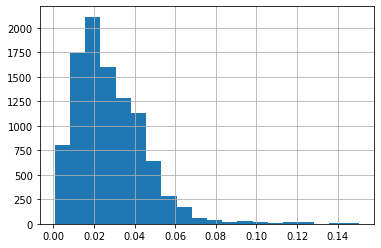

In [8]:
# how does it behave?
dataset['distance'].hist(bins=20)

## Separating Datasets
Let's put aside the submission data with empty times as we will predict them later, this is
20% of our data according to the dataset profile. The remaining set will be split into 70% and
30% for train and validation purposes.

In [15]:
# make a separate copy for the submission set
submission_dataset = dataset[np.isnan(dataset['total_minutes'])].copy()

# save and profile it
def profile(df, name, minimal=True):
    prof = ProfileReport(df, minimal=minimal)
    prof.to_file(name)
profile(submission_dataset, './profiles/submission.html')

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
# make a separate copy for the model
model_dataset = dataset[np.isnan(dataset['total_minutes']) == 0].copy()

# separate our label total_minutes from the set
total_minutes = model_dataset['total_minutes'].copy()
model_dataset.drop('total_minutes', axis=1, inplace=True)

# impute some values remaining in pop_wei, sum_wei, pop_uni, sum_uni
model_dataset = model_dataset.fillna(model_dataset.mean())

model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            8000 non-null   float64
 1   lng            8000 non-null   float64
 2   on_demand      8000 non-null   bool   
 3   unix_time      8000 non-null   float64
 4   sum_uni        8000 non-null   float64
 5   sum_wei        8000 non-null   float64
 6   pop_uni        8000 non-null   float64
 7   pop_wei        8000 non-null   float64
 8   seniority      8000 non-null   int64  
 9   found_rate     8000 non-null   float64
 10  picking_speed  8000 non-null   float64
 11  accepted_rate  8000 non-null   float64
 12  rating         8000 non-null   float64
 13  lat_store      8000 non-null   float64
 14  lng_store      8000 non-null   float64
 15  branch_size    8000 non-null   int64  
 16  city           8000 non-null   int64  
 17  distance       8000 non-null   float64
dtypes: bool(

## Modelling stage
We complete the preamble to train a LightGBM model with the dataset. LightGBM model
parameters are tuneable:

(TODO: Fill these fields)
* boosting_type:
* objective:
* metric:
* num_leaves:
* learning_rate:
* feature_fraction:
* bagging_fraction:
* bagging_freq:
* verbose:

In [32]:
#make train and test splits
random_state = 0
x_train, x_test, y_train, y_test = train_test_split(model_dataset, total_minutes,
                                                    test_size=0.3, random_state=random_state)
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
}

## Training stage

In [43]:
model_lgb = lgb.train(params, lgb_train, num_boost_round=500,
                      valid_sets=lgb_eval, early_stopping_rounds=50, verbose_eval=False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [44]:
# check predictions accuracy
lgb_train_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
lgb_test_pred = model_lgb.predict(x_test, num_iteration=model_lgb.best_iteration)

Average error in minutes = 16.93791095552595


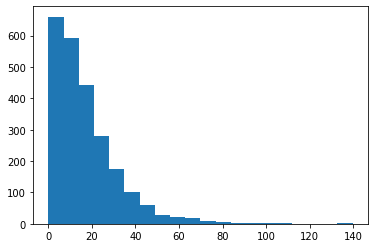

In [46]:
# plot the error on test dataset
plt.hist(abs(lgb_test_pred - y_test), bins=20)
print(f'Average error in minutes = {np.mean(abs(lgb_test_pred - y_test))}')

Average minutes of an order = 80.55005531193764


(array([ 16., 146., 325., 397., 443., 298., 247., 180., 133.,  88.,  57.,
         35.,  18.,  10.,   2.,   3.,   1.,   0.,   0.,   1.]),
 array([ 11.96948947,  25.16596267,  38.36243586,  51.55890906,
         64.75538226,  77.95185546,  91.14832866, 104.34480185,
        117.54127505, 130.73774825, 143.93422145, 157.13069465,
        170.32716785, 183.52364104, 196.72011424, 209.91658744,
        223.11306064, 236.30953384, 249.50600704, 262.70248023,
        275.89895343]),
 <BarContainer object of 20 artists>)

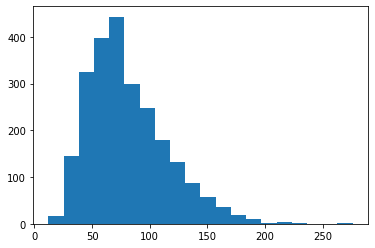

In [47]:
# plot the magnitude of values we're working with
print(f'Average minutes of an order = {np.mean(y_test)}')
plt.hist(y_test, bins=20)

In average, we miss the mark by 17 minutes and an order takes around 80 minutes to process.
Honestly not so bad for a baseline model-and-go kind of method! Maybe this model is enough
to achieve a better performance, let's tune it!

## Tuning our baseline
(TODO: Tune parameters and use shap to understand where our model gets insights)